In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [73]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import random

from petl import fromcsv, look, fieldnames, values, head, tail

import seaborn as sns

from mpl_toolkits.basemap import Basemap

import os

from datetime import datetime

import nltk

from sklearn.linear_model import LogisticRegression

from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.metrics import confusion_matrix

from matplotlib import cm as cmap

In [4]:
data = pd.read_csv('datasample/concatenated_dataset.txt', sep="|", header = None)

data.columns = ['getsocial_user_id', 'gramble_sdk_version', 'app_id', 'app_version',
                'ts', 'duration', '_type', 'country', 'city', 'os', 'os_version', 
                'model', 'wifi', 'screen_width', 'screen_height', 'screen_dpi']  

time_date = pd.DatetimeIndex(data['ts'])
data['year'] = time_date.year
data['month'] = time_date.month
data['dayofweek'] = time_date.dayofweek
data['day'] = time_date.day
data['hour'] = time_date.hour

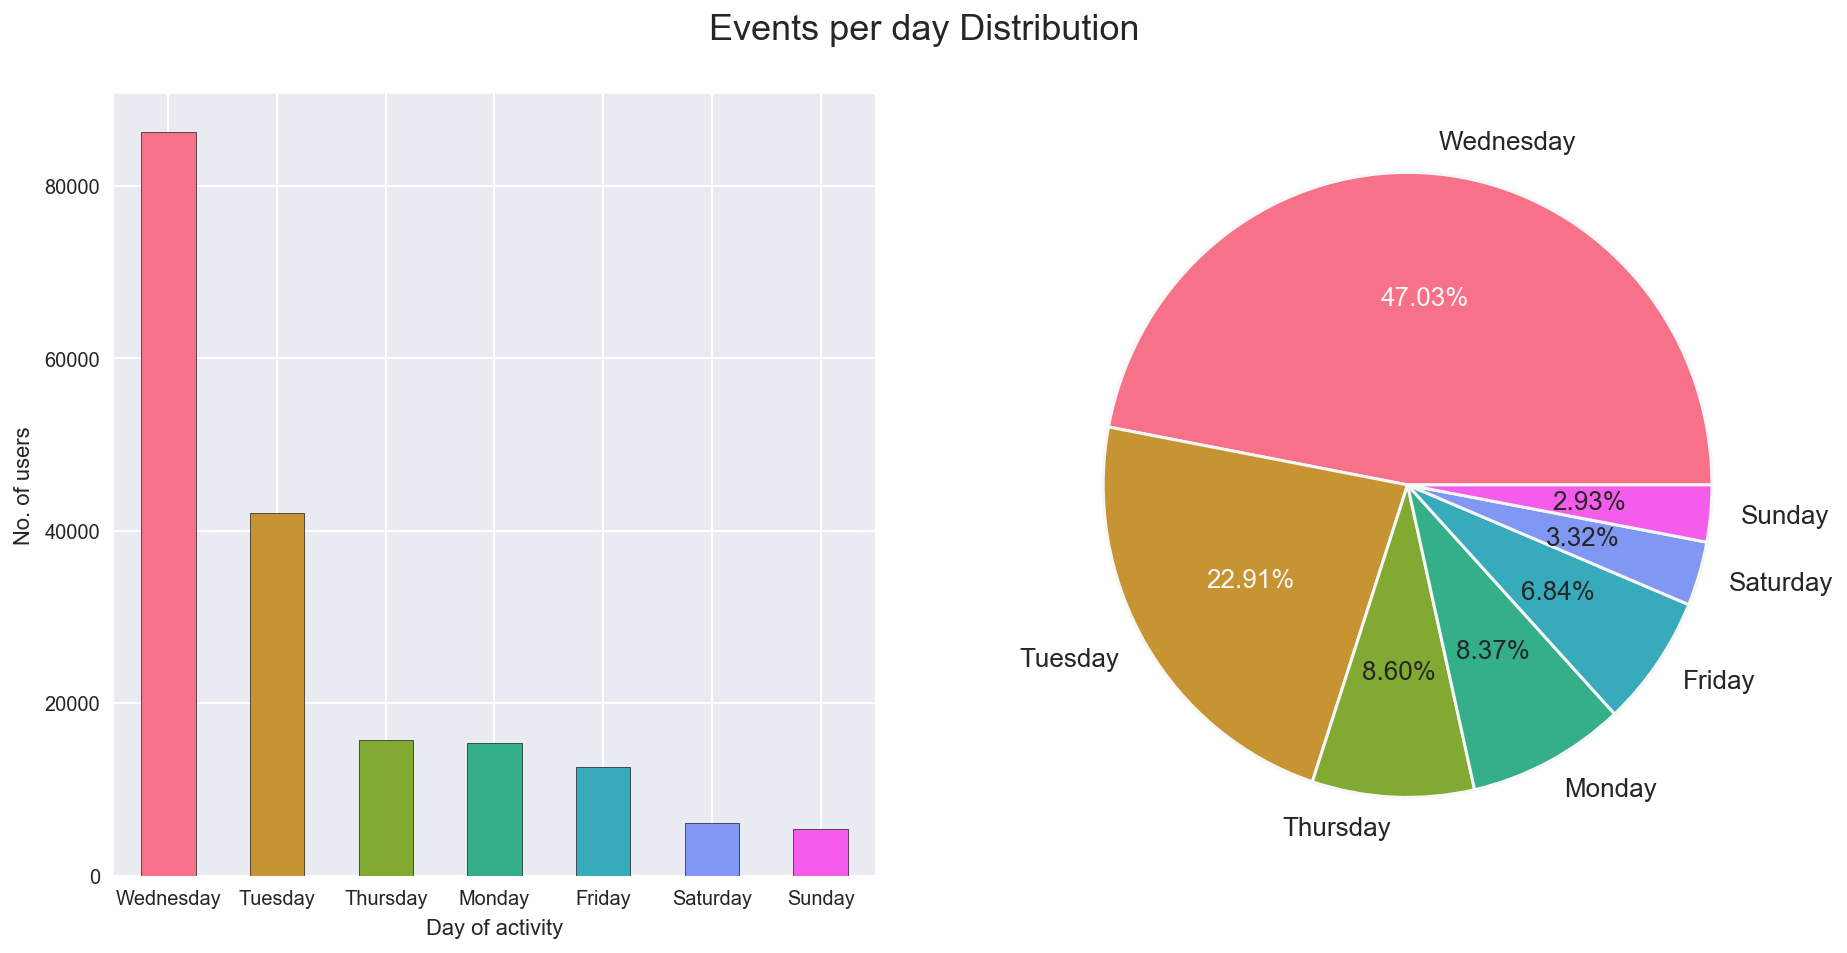

In [5]:
f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("Events per day Distribution", fontsize = 18.)

_ = data.dayofweek.value_counts().plot.bar(ax = ax[0], rot = 0, color = (sns.color_palette("husl",7))).set(xticklabels = ["Wednesday", "Tuesday","Thursday","Monday","Friday","Saturday","Sunday"])
_ = data.dayofweek.value_counts().plot.pie(labels = ("Wednesday", "Tuesday","Thursday","Monday","Friday","Saturday","Sunday"), autopct = "%.2f%%", label = "", fontsize = 13., ax = ax[1],\
                                         colors = (sns.color_palette("husl",7)), wedgeprops = {"linewidth": 1.5, "edgecolor": "#F7F7F7"}), ax[1].texts[1].set_color("#F7F7F7"), ax[1].texts[3].set_color("#F7F7F7")
_ = ax[0].set_xlabel("Day of activity"), ax[0].set_ylabel("No. of users")

Considering wednesday and Tuesday are the most popular days among users, we will try to perform the following prediction:
    
    We're supossing that Get social will launch a marketing campaing to enhance their participation in the market.
    Then, we want to send our clients an attractive promotion only on Wednesdays or Tuesday at the top hours because it has been a succesful campaing in the previous months. As this hypotetical case doesn't give us enough information to determine the specific day and time the user is connected, we want to predict with the remaining information whether the costumer would be the ideal customer to receive our attractive promotion.
    
    The manner we consider succesfull a prediction is by finding the ideal customer,the ideal customer is that guy which very likely would spend time with Get Social on wednesdays or Tuesdays as we have real information that will help us to measure the performance of our predictor.

We're considering using a logistic regression model which help us to predict whether a user would be the ideal candidate to send him/her our attractive promotion.

To make that possible we label our dataset as YES and NO classes, in which the class YES is to those users who have played either on Wednesdays or Tuesdays and NO the remaining users.

In [6]:
offers_campaing = np.array(data.dayofweek.values).tolist()

offer_label_list = []

for offer in offers_campaing:
    offer_mask = ((offer == 1) | (offer ==2))
    if offer_mask is True:
            offer_label_list.append('Yes')
            offer_mask = None
    else:
            offer_label_list.append('No')
data['dayofweek_label'] = offer_label_list

We transform the categorical attributes into a numerical form in order to consider them for training the model.



In [7]:
def label_class(att_name,class_labels):
    
    label_list = []
    label = att_name + '_label'
    att_data = data[att_name].values
    
    
    for value in att_data:
        if value is np.nan:
            label_list.append(0)
        else:
            
            label_list.append(1 + class_labels.index(value))
        
    data[label] = label_list
    
    return 
    

In [8]:
class_labels = ['app_session','content_session','user_register', 'user_login',
                       'social_bar_session','invite_clicked','user_activity_post','user_follows',
                       'invite_failed','invite_sent','push_notification_sent','invite_canceled',
                       'user_activity_action_click','sdk_error','push_notification_received',
                       'user_comment_post','user_leaderboards_scores','push_notification_clicked']

label_class('_type',class_labels)


In [9]:
class_labels = ["Ashburn","-"]
label_class('city',class_labels)

In [10]:
class_labels = ["US","-"]
label_class('country',class_labels)

In [11]:
class_labels = ["Android","iOS"]
label_class('os',class_labels)

In [12]:
class_labels = ["t","f"]
label_class('wifi',class_labels)

In [13]:
class_labels = ["5.0.0","5.0.1","5.0.1-beta","5.0.2","5.0.3","5.0.4"]
label_class('gramble_sdk_version',class_labels)

In [42]:
data = data.dropna()
data = data.iloc[np.random.permutation(len(data))]

In [43]:
features = [ 'getsocial_user_id', 'gramble_sdk_version_label', 'app_id', 
                 'duration','day','month','hour','_type_label','country_label', 'city_label','os_label','wifi_label', 
                'screen_width', 'screen_height', 'screen_dpi']



data_features, data_y = data[features].values, data['dayofweek_label'].values

In [44]:
size = int(0.7*len(data_features))

data_features_train, data_classes_train = data_features[:size], data_y[:size]
data_features_test, data_classes_test = data_features[-size:], data_y[-size:]

In [78]:
logreg = LogisticRegression(random_state = 20).fit(data_features_train, data_classes_train)

In [79]:
confusion_matrices = []

data_classes_pred = logreg.predict(data_features_test)
cm = confusion_matrix(data_classes_test, data_classes_pred)
confusion_matrices.append(cm)


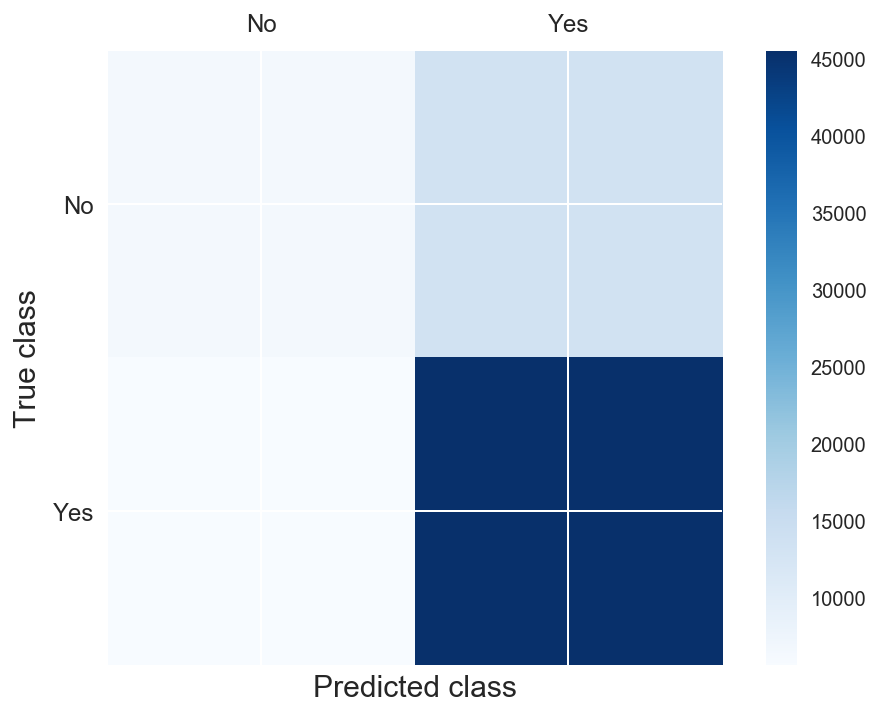

In [82]:
tip_labels = ['No', 'No','Yes']


first = True
cm = None

for cm_iter in confusion_matrices:
    if first:
        cm = cm_iter.copy()
        first = False
    else:
        cm = cm + cm_iter

fig, axes = plt.subplots()

colorbar = axes.matshow(cm, cmap=cmap.Blues)
fig.colorbar(colorbar)

axes.set_xlabel('Predicted class', fontsize=15)
axes.set_ylabel('True class', fontsize=15)

axes.set_xticklabels(tip_labels)
axes.set_yticklabels(tip_labels)

axes.tick_params(labelsize=12)


f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("Normalized Confusion Matrices", fontsize = 18.)
def make_cm(p, t, axis):
    cm = confusion_matrix(tY, np.argmax(p, axis = 1))
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    _ = sns.heatmap(cm, square = True, xticklabels = ["Deceased", "Alive"], annot = True,
                    annot_kws = {"fontsize": 13}, yticklabels = ["Deceased", "Alive"],
                    cbar = True, cbar_kws = {"orientation": "horizontal"}, ax = ax[axis], cmap = "Blues").set(

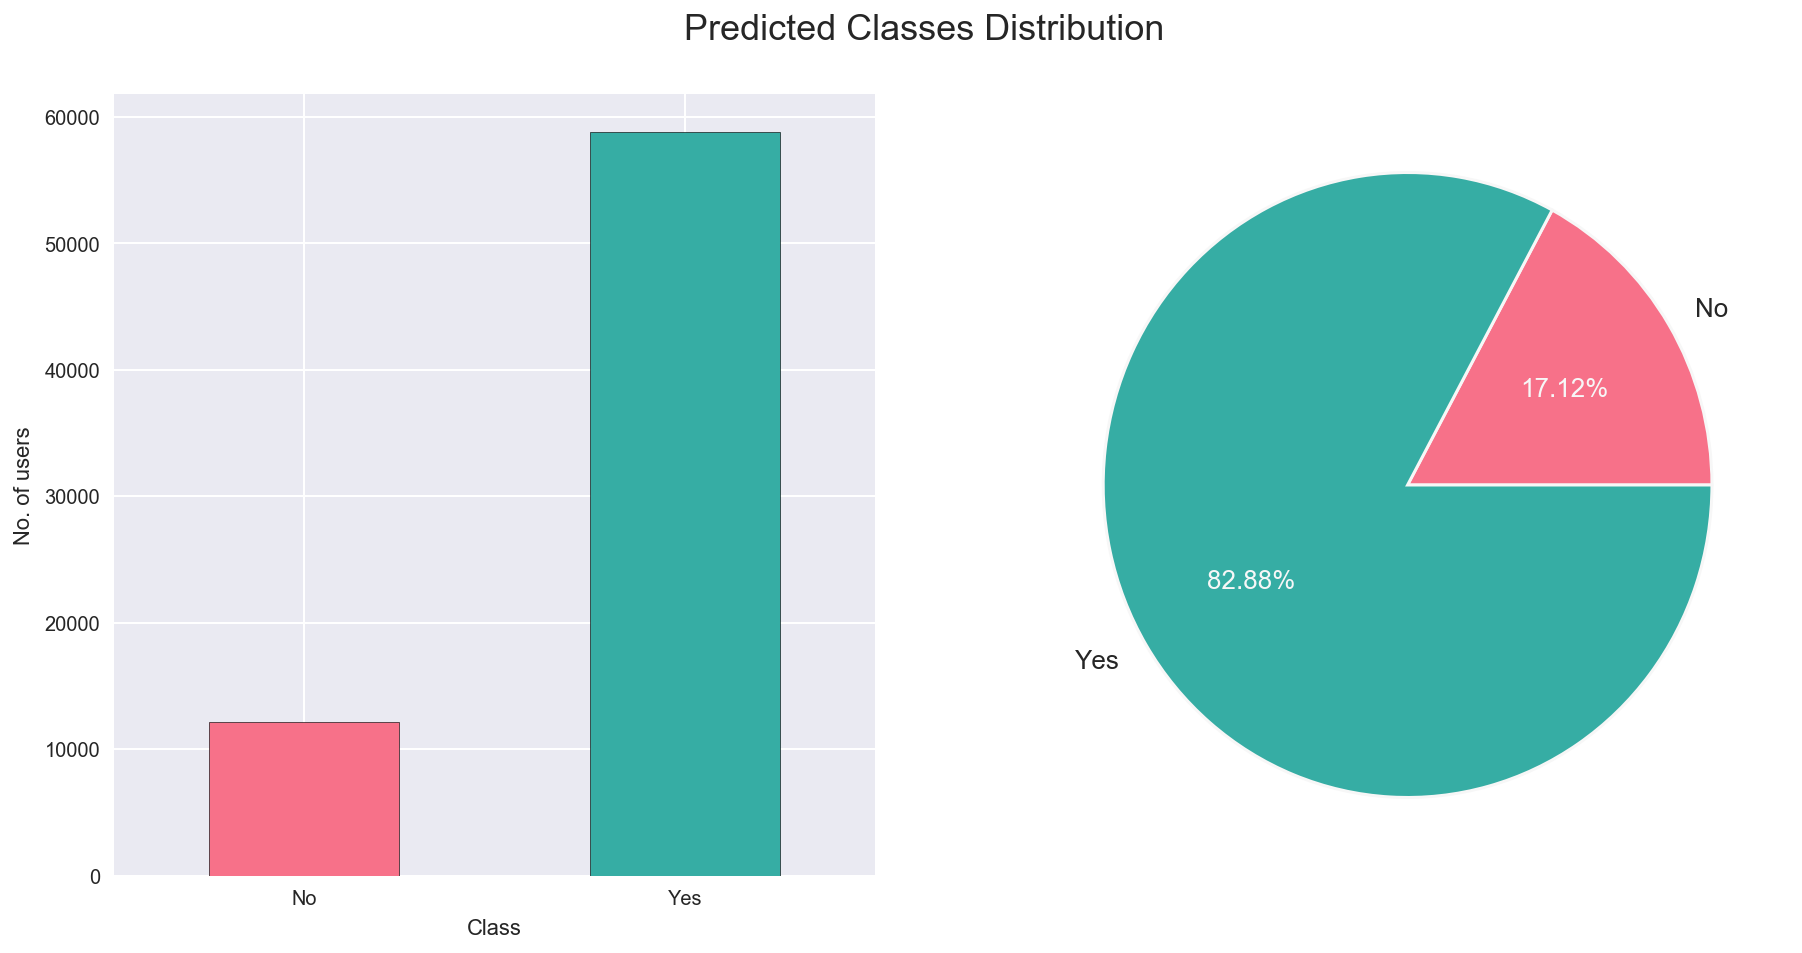

In [117]:
preds_lr = logreg.predict_proba(data_features_test)
preds = logreg.predict(data_features_test)
predicciones = pd.DataFrame(preds)
#predicciones.groupby(0).size().plot(kind='bar')

f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("Predicted Classes Distribution", fontsize = 18.)
_ = predicciones.groupby(0).size().plot.bar(ax = ax[0], rot = 0, color = (sns.color_palette("husl",2))).set(xticklabels = ["No","Yes"])
_ = predicciones.groupby(0).size().plot.pie(labels = ("No","Yes"), autopct = "%.2f%%", label = "", fontsize = 13., ax = ax[1],\
                                         colors = (sns.color_palette("husl",2)), wedgeprops = {"linewidth": 1.5, "edgecolor": "#F7F7F7"}), ax[1].texts[1].set_color("#F7F7F7"), ax[1].texts[3].set_color("#F7F7F7")
_ = ax[0].set_xlabel("Class"), ax[0].set_ylabel("No. of users")

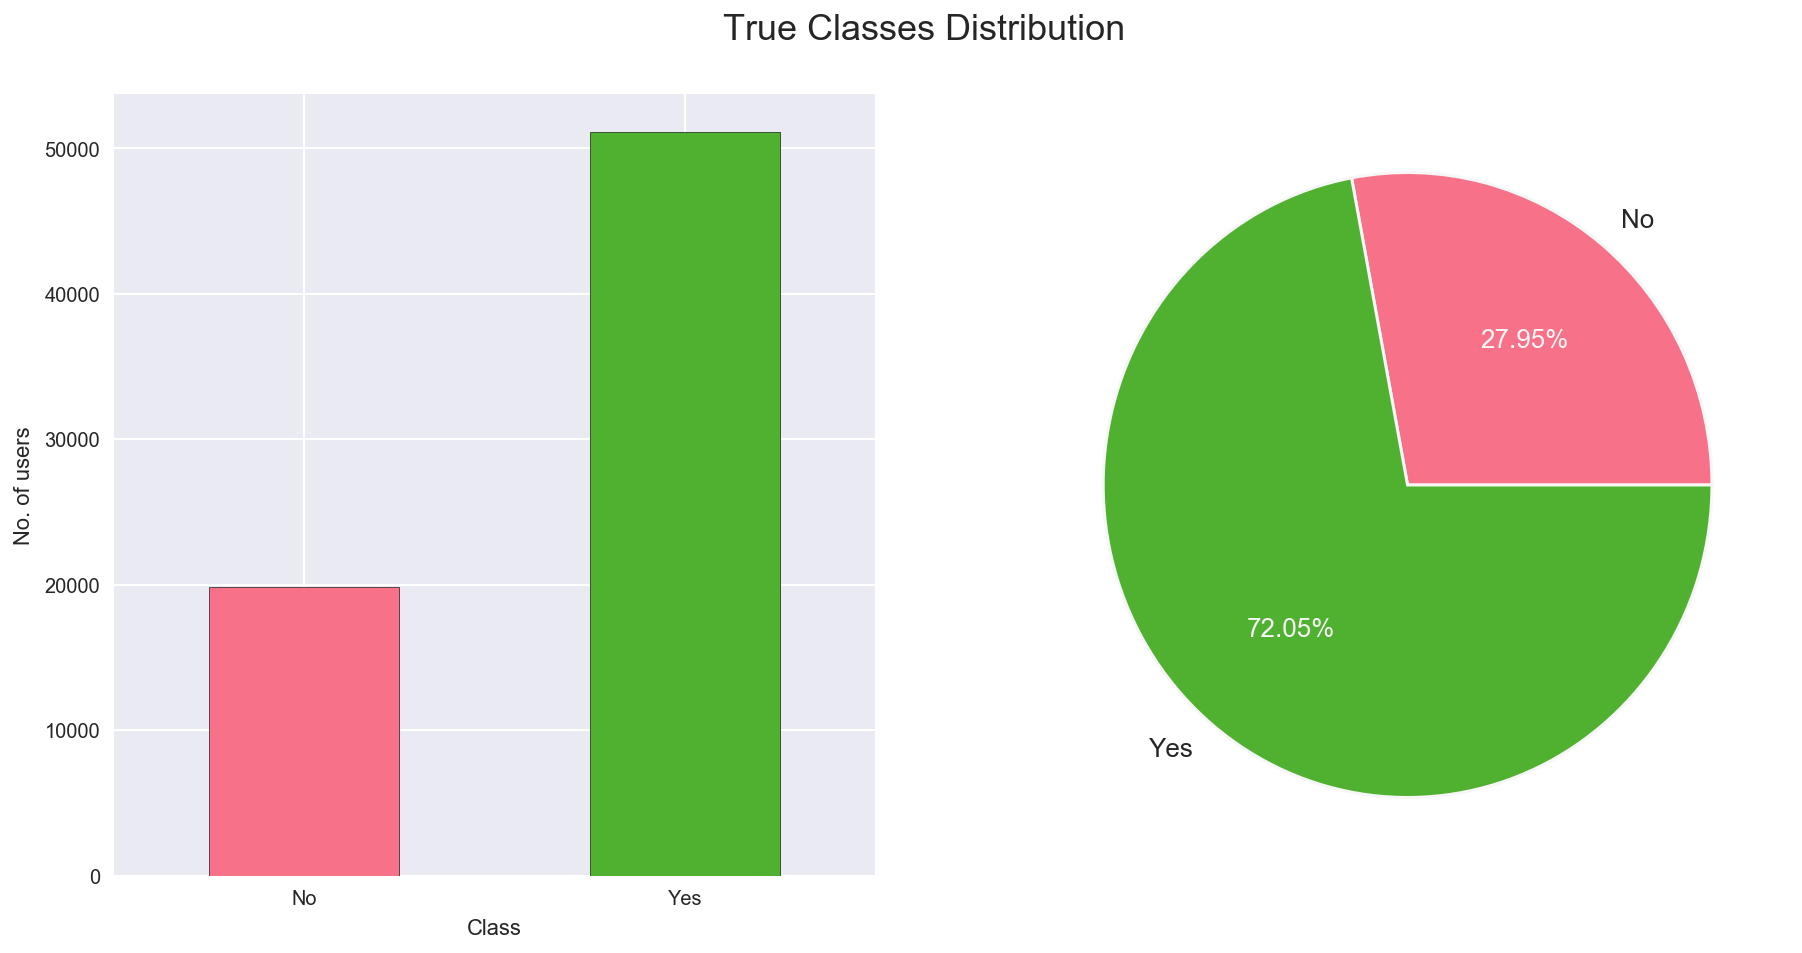

In [118]:
predics= pd.DataFrame(data_classes_test)
#predics.groupby(0).size().plot(kind='bar')

f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("True Classes Distribution", fontsize = 18.)
_ = predics.groupby(0).size().plot.bar(ax = ax[0], rot = 0, color = (sns.color_palette("husl",3))).set(xticklabels = ["No","Yes"])
_ = predics.groupby(0).size().plot.pie(labels = ("No","Yes"), autopct = "%.2f%%", label = "", fontsize = 13., ax = ax[1],\
                                         colors = (sns.color_palette("husl",3)), wedgeprops = {"linewidth": 1.5, "edgecolor": "#F7F7F7"}), ax[1].texts[1].set_color("#F7F7F7"), ax[1].texts[3].set_color("#F7F7F7")
_ = ax[0].set_xlabel("Class"), ax[0].set_ylabel("No. of users")